In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_VAE, load_pretrained_GLOW
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE
from core.fisher_utils_VAE import AUTO_VAE_CIFAR, AUTO_VAE_FMNIST
from core.fisher_utils_GLOW import Calculate_fisher_GLOW, Calculate_score_GLOW
from core.fisher_utils_GLOW import AUTO_GLOW_CIFAR, AUTO_GLOW_FMNIST
from core.visualize import plot_hist, AUROC

# Define Global Variables & Initialize

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'VAE': {'cifar10': 0, 'fmnist': 0},
           'GLOW': {'cifar10': 0, 'fmnist': 0}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'VAE': {'cifar10': 0, 'fmnist': 0},
             'GLOW': {'cifar10': 0, 'fmnist': 0}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'VAE': {'cifar10': {}, 'fmnist': {}},
          'GLOW': {'cifar10': {}, 'fmnist': {}}}

## Note

dictionary 형태로 결괏값을 저장합니다.   
key의 형태는 model - in-dist - out-dist 입니다.  
(ex)  
FISHERs['VAE']['cifar10'] : VAE모델, cifar10훈련 시 나온 Fisher Inverse matrix
NORM_FACs['VAE']['cifar10'] : VAE모델, cifar10훈련 시 나온 Normalize_Factor  
SCOREs['VAE']['cifar10']['svhn'] : VAE모델, cifar10 (In), svhn (Out) 시 score  

# VAE-CIFAR10

In [30]:
train_dist = 'cifar10'
opt = config.VAE_cifar10
netE, netG = load_pretrained_VAE(option=train_dist, ngf=128, nz=200, beta=1)

dicts = [netE.conv1.weight]
#dicts = [netE.conv1.weight, netG.main[-1].weight,]

In [31]:
a, b, _scores = AUTO_VAE_CIFAR(netE, netG, dicts, max_iter=[10000, 5000], loss_type='ELBO')

Files already downloaded and verified


Calculate Fisher VAE:  20%|██████████▌                                          | 9999/50000 [06:58<27:56, 23.87step/s]


Files already downloaded and verified


Calculate Score VAE:  50%|██████████████████████████▉                           | 4999/10000 [01:29<01:29, 56.15step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score VAE: 100%|█████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 51.31step/s]


Files already downloaded and verified


Calculate Score VAE:  50%|██████████████████████████▉                           | 4999/10000 [01:26<01:26, 58.07step/s]


In [32]:
FISHERs['VAE']['cifar10'] = a[dicts[0]]
NORM_FACs['VAE']['cifar10'] = b[dicts[0]]
for ood in opt.ood_list:
    SCOREs['VAE']['cifar10'][ood] = _scores[ood][dicts[0]]

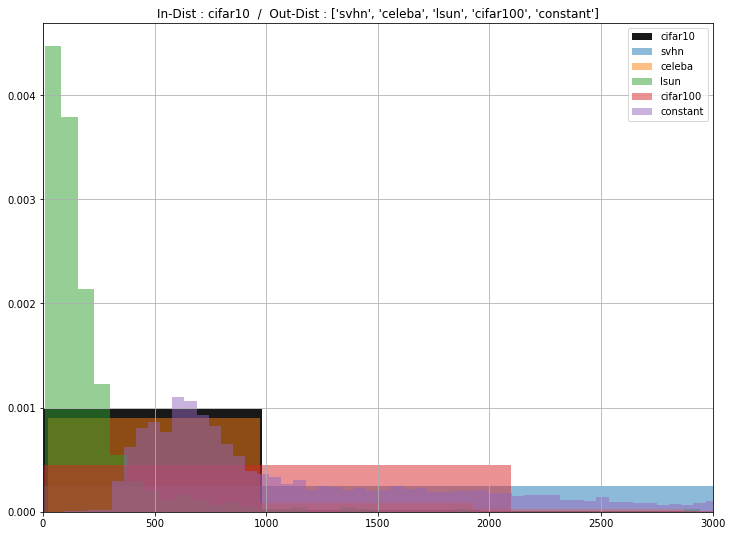

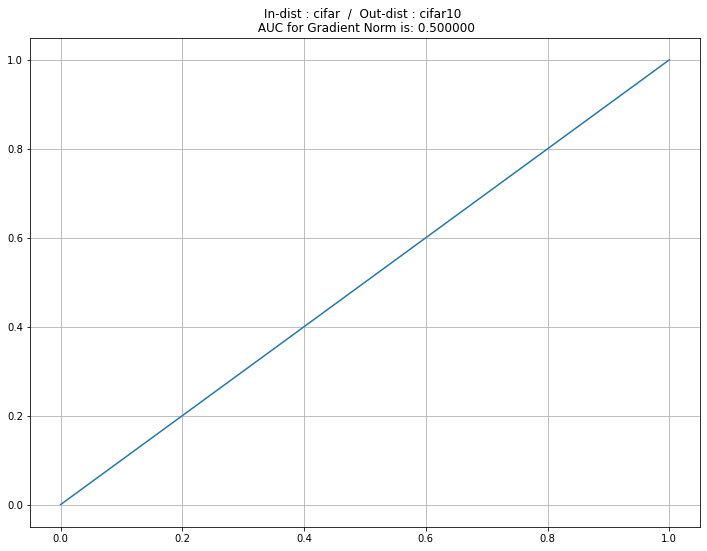

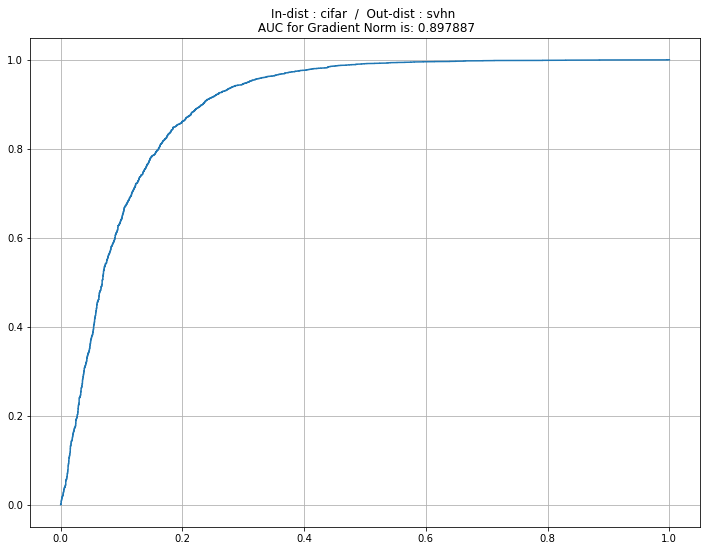

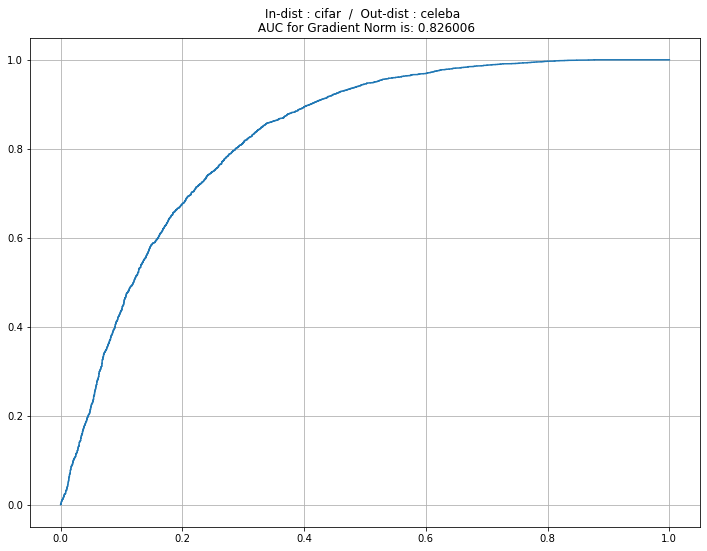

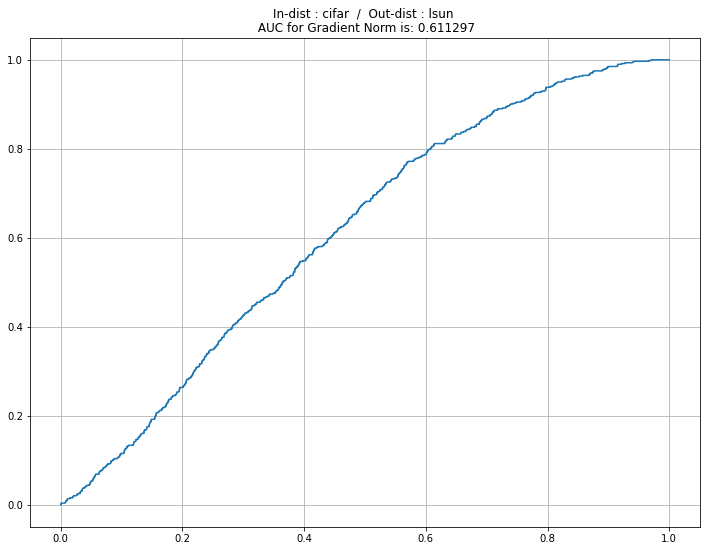

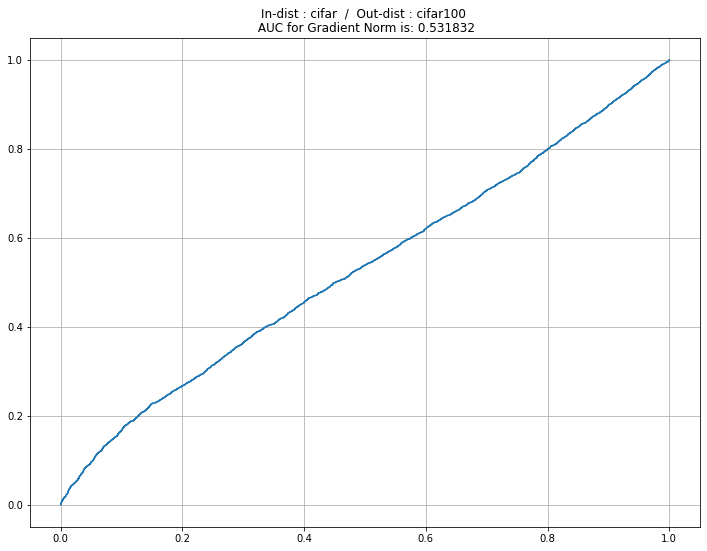

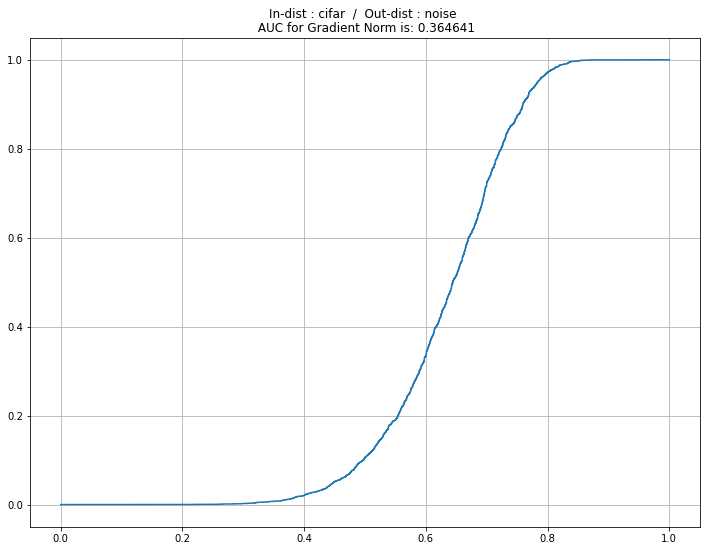

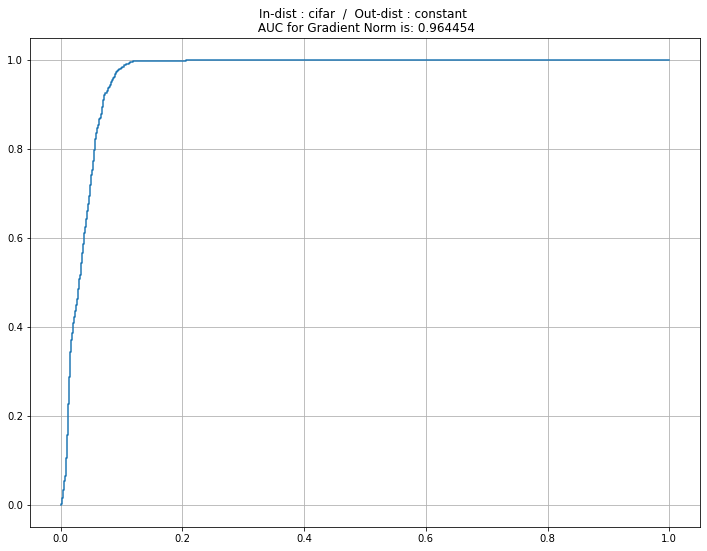

In [33]:
# Histogram
temp = opt.ood_list.copy()
temp.remove('noise') # 'noise' makes the Histogram too dirty...
args = [SCOREs['VAE']['cifar10'][ood] for ood in temp]
bins = [3000, 1000, 3000, 3000, 3000, 3000]
plot_hist(*args, bins=bins, labels=temp, xlim=[0, 3000])


# AUROC curve
for ood in opt.ood_list:
    args = [
        SCOREs['VAE']['cifar10']['cifar10'],
        SCOREs['VAE']['cifar10'][ood],
    ]
    labels = ['cifar10', ood]
    AUROC(*args, labels=labels)

# VAE-FMNIST

In [34]:
train_dist = 'fmnist'
opt = config.VAE_fmnist
netE, netG = load_pretrained_VAE(option=train_dist, ngf=128, nz=200, beta=1)

#dicts = [netG.main[-1].weight, netE.conv1.weight]
dicts = [netE.conv1.weight]

In [35]:
a, b, _scores = AUTO_VAE_FMNIST(netE, netG, dicts, max_iter=[10000, 5000], loss_type='ELBO')

Calculate Score VAE:   5%|██▋                                                    | 499/10000 [00:07<02:21, 67.25step/s]

0it [00:00, ?it/s]

Extracting ../data\KMNIST\raw\train-images-idx3-ubyte.gz to ../data\KMNIST\raw


0it [00:00, ?it/s]

Extracting ../data\KMNIST\raw\train-labels-idx1-ubyte.gz to ../data\KMNIST\raw


0it [00:00, ?it/s]

Extracting ../data\KMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\KMNIST\raw


0it [00:00, ?it/s]

Extracting ../data\KMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\KMNIST\raw
Processing...
Done!


C:\Users\shinypond\.conda\envs\ycy\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




Calculate Score VAE:   0%|                                                                 | 0/10000 [00:00<?, ?step/s]



Calculate Score VAE:   0%|                                                       | 1/10000 [00:00<2:00:41,  1.38step/s]



Calculate Score VAE:   0%|                                                         | 8/10000 [00:00<13:14, 12.57step/s]



Calculate Score VAE: 

0it [00:00, ?it/s]

Extracting ../data\omniglot-py\images_evaluation.zip to ../data\omniglot-py







Calculate Score VAE:   0%|                                                                 | 0/13180 [00:00<?, ?step/s]




Calculate Score VAE:   0%|                                                       | 1/13180 [00:01<5:07:28,  1.40s/step]




Calculate Score VAE:   0%|                                                         | 9/13180 [00:01<27:34,  7.96step/s]




Calculate Score VAE:   0%|                                                        | 17/13180 [00:01<13:39, 16.06step/s]




Calculate Score VAE:   0%|                                                        | 25/13180 [00:01<08:53, 24.66step/s]




Calculate Score VAE:   0%|▏                                                       | 33/13180 [00:01<06:36, 33.19step/s]




Calculate Score VAE:   0%|▏                                                       | 41/13180 [00:01<05:17, 41.32step/s]




Calculate Score VAE:   0%|▏                                                       | 48/13180 [00:02<04:37, 47.28step/s]




Cal

In [41]:
FISHERs['VAE']['fmnist'] = a[dicts[0]]
NORM_FACs['VAE']['fmnist'] = b[dicts[0]]
for ood in opt.ood_list:
    SCOREs['VAE']['fmnist'][ood] = _scores[ood][dicts[0]]

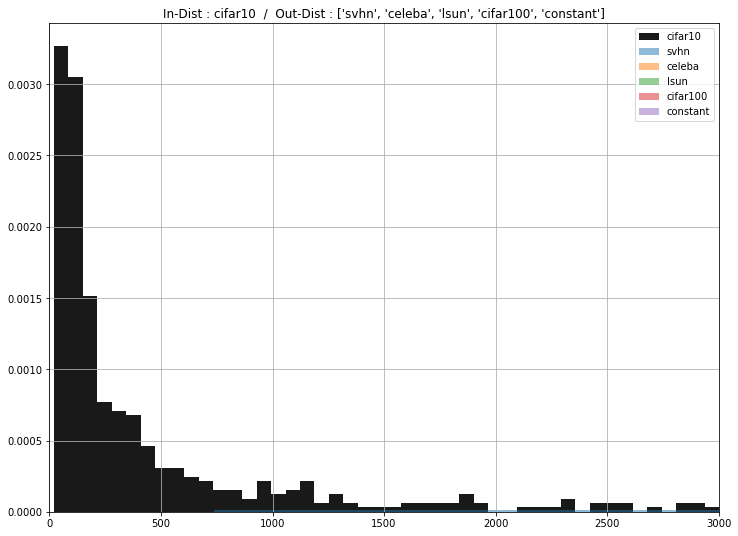

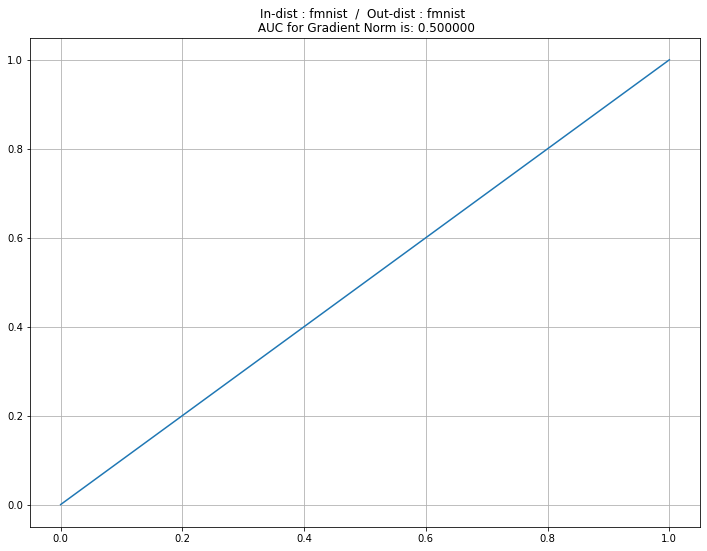

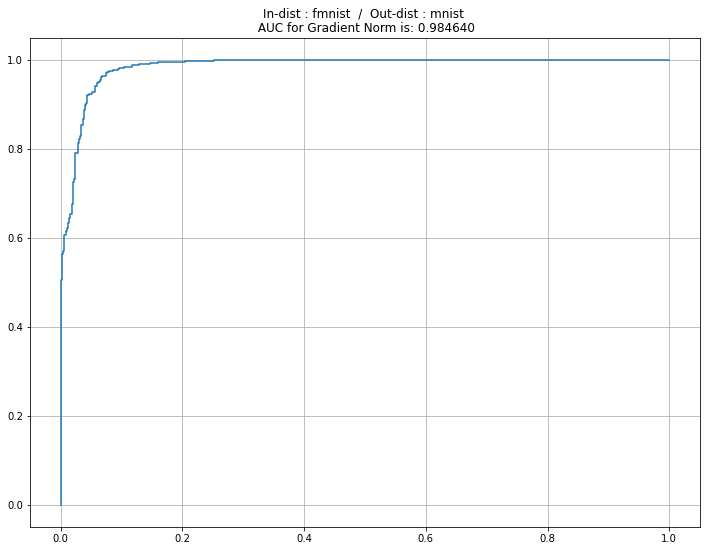

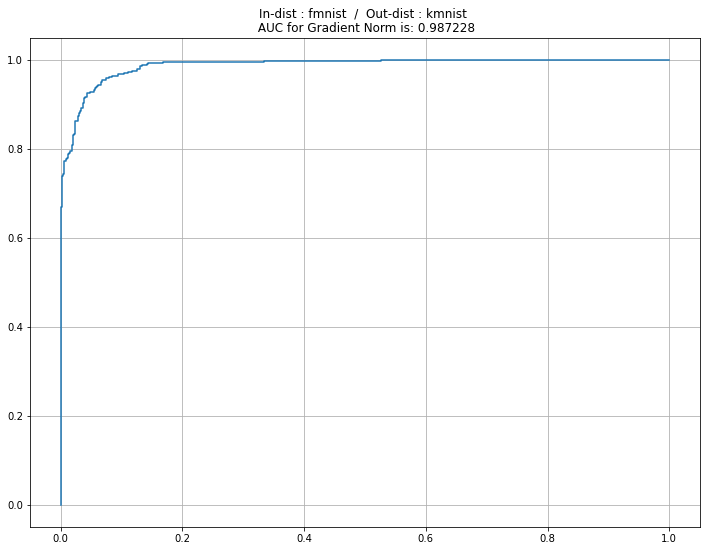

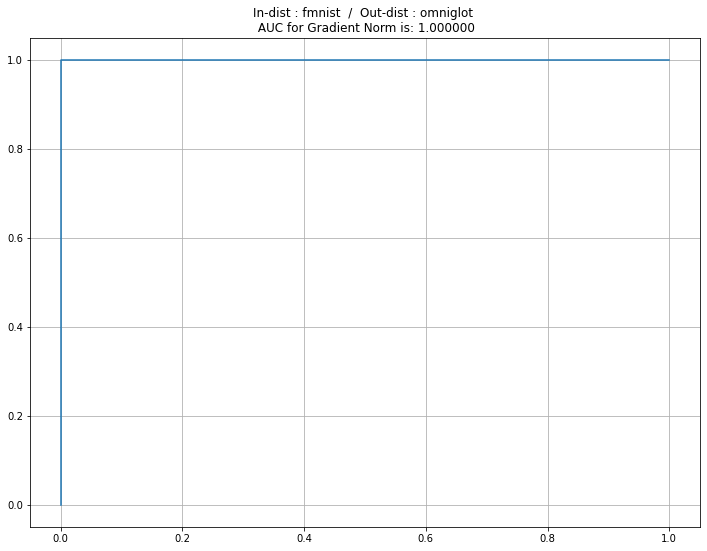

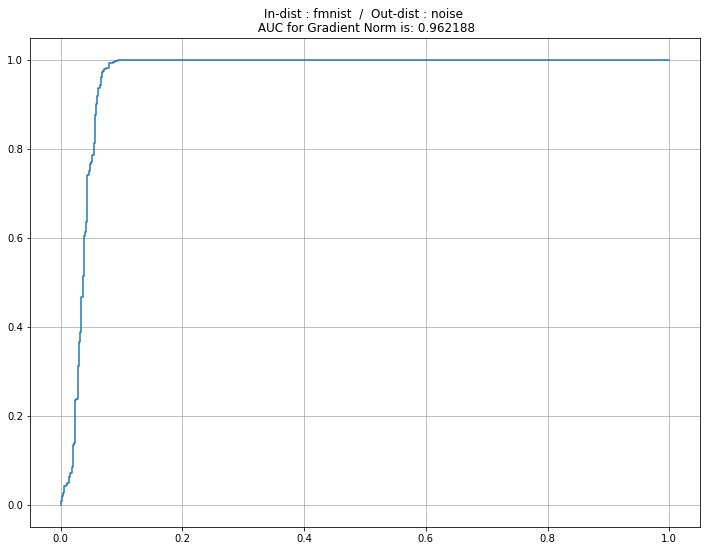

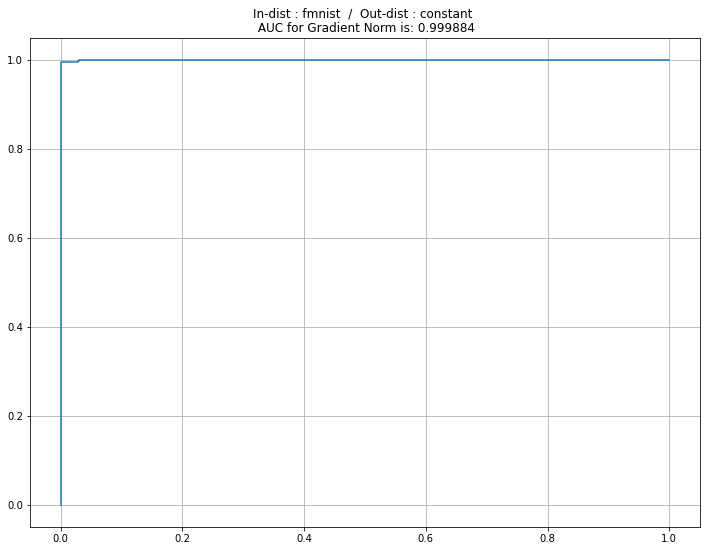

In [42]:
# Histogram
args = [SCOREs['VAE']['fmnist'][ood] for ood in opt.ood_list]
bins = [1000, 100, 100, 100, 100, 100]
plot_hist(*args, bins=bins, labels=temp, xlim=[0, 3000])


# AUROC curve
for ood in opt.ood_list:
    args = [
        SCOREs['VAE']['fmnist']['fmnist'],
        SCOREs['VAE']['fmnist'][ood],
    ]
    labels = ['fmnist', ood]
    AUROC(*args, labels=labels)

# GLOW-CIFAR10

In [160]:
train_dist = 'cifar10'
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=train_dist)

dicts = [model.flow.layers[-1]]

In [161]:
a, b, c, d, e, f, g = AUTO_GLOW_CIFAR(model, dicts)
GRADs['GLOW']['cifar10'] = a
NORM_FACs['GLOW']['cifar10'] = b
Gradients['GLOW']['cifar10']['cifar10'] = c
Gradients['GLOW']['cifar10']['svhn'] = d
Gradients['GLOW']['cifar10']['celeba'] = e
Gradients['GLOW']['cifar10']['lsun'] = f
Gradients['GLOW']['cifar10']['noise'] = g

Files already downloaded and verified


Calculate Fisher GLOW:   2%|█                                                 | 1001/50000 [04:28<3:38:56,  3.73step/s]


Files already downloaded and verified


Calculate Score GLOW:   4%|██▏                                                   | 401/10000 [01:48<43:22,  3.69step/s]


Using downloaded and verified file: ../data/test_32x32.mat


Calculate Score GLOW:   4%|██▏                                                   | 401/10000 [01:46<42:33,  3.76step/s]


In [12]:
# Histogram
args = [
    Gradients['GLOW']['cifar10']['cifar10'],
    Gradients['GLOW']['cifar10']['svhn'],
    Gradients['GLOW']['cifar10']['celeba'],
    Gradients['GLOW']['cifar10']['lsun'],
    Gradients['GLOW']['cifar10']['noise'],
]
bins = [100, 100, 100, 100, 100]
labels = ['cifar10', 'svhn', 'celeba', 'lsun', 'noise']
xlim = [0, 2]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
args = [
    Gradients['GLOW']['cifar10']['cifar10'],
    Gradients['GLOW']['cifar10']['svhn'],
]
labels = ['cifar', 'svhn']
AUROC(*args, labels=labels)

KeyError: 'cifar10'

# GLOW-FMNIST (미완성)

In [ ]:
train_dist = 'fmnist'
opt = config.GLOW_fmnist # 에러날 거
netE, netG = load_pretrained_VAE(option=train_dist)

dicts = [netG.main[-1].weight, netE.conv1.weight]

In [ ]:
a, b, c, d, e = AUTO_GLOW_FNNIST(netE, netG, dicts)
GRADs['GLOW']['fmnist'] = a
NORM_FACs['GLOW']['fmnist'] = b
Gradients['GLOW']['fmnist']['fmnist'] = c
Gradients['GLOW']['fmnist']['mnist'] = d
Gradients['GLOW']['fmnist']['noise'] = e

In [ ]:
# Histogram
args = [
    Gradients['GLOW']['fmnist']['fmnist'],
    Gradients['GLOW']['fmnist']['mnist'],
    Gradients['GLOW']['fmnist']['noise'],
]
bins = [100, 100, 100]
labels = ['fmnist', 'mnnist', 'noise']
xlim = [0, 5]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
args = [
    Gradients['GLOW']['fmnist']['fmnist'],
    Gradients['GLOW']['fmnist']['mnist'],
]
labels = ['fmnist', 'mnist']
AUROC(*args, labels=labels)